# Crunchbase Startup Investments

This code uses data from Crunchbase containing information on investments in various startups up through October 2013.  The data can be obtained through this link: https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv.  The code here seeks to minimize the amount of memory needed to store the data and to help improve the speed of data processing.  As a result, the data is processed in chunks and datatypes are converted into variables that require less storage where possible (e.g. string to categorical, string to int, float to int).  This exercise is able to reduce the memory storage from 45MB to 7MB or a size that is over 6 times smaller than the original file.

In [4]:
#Assume we only have 10MB of available memory for processing
import pandas as pd

temp = pd.read_csv("crunchbase-investments.csv", encoding = "ISO-8859-1", parse_dates=["funded_at"], nrows=5)
print(temp)
print(temp.dtypes)
missing = temp.isnull().sum()
print(missing)
print(missing["company_city"])
print(temp.memory_usage(deep=True))
temp["company_city"] = [st.upper() for st in temp["company_city"].astype(str)]

     company_permalink company_name company_category_code  \
0    /company/advercar     AdverCar           advertising   
1  /company/launchgram   LaunchGram                  news   
2        /company/utap         uTaP             messaging   
3    /company/zoopshop     ZoopShop              software   
4    /company/efuneral     eFuneral                   web   

  company_country_code company_state_code         company_region  \
0                  USA                 CA                 SF Bay   
1                  USA                 CA                 SF Bay   
2                  USA                NaN  United States - Other   
3                  USA                 OH               Columbus   
4                  USA                 OH              Cleveland   

    company_city          investor_permalink      investor_name  \
0  San Francisco  /company/1-800-flowers-com  1-800-FLOWERS.COM   
1  Mountain View        /company/10xelerator        10Xelerator   
2            NaN       

In [8]:
#across all chunks compute, cols missing value counts, default data type, memory footprint,
#total memory footprint, columns that can be dropped
#columns to drop that are not useful
drop_cols = ["company_permalink","investor_permalink","funded_quarter"]
temp = pd.read_csv("crunchbase-investments.csv", encoding = "ISO-8859-1", parse_dates=["funded_at"], nrows=10)
keep_cols = []
for c in temp.columns:
    if c not in drop_cols:
        keep_cols.append(c)

col_memory_footprint = {}
missing_values = {}
memory_footprints = []
chunk_iter = pd.read_csv("crunchbase-investments.csv", encoding = "ISO-8859-1", usecols=keep_cols, chunksize=5000)
for chunk in chunk_iter:    
    #sums the missing values per column
    missing = chunk.isnull().sum()
    col_memory = chunk.memory_usage(deep=True)
    for c in keep_cols:
        if c in col_memory_footprint:
            missing_values[c] = missing_values[c] + missing[c]
            col_memory_footprint[c]=col_memory_footprint[c] + col_memory[c]
        else:
            col_memory_footprint[c]=col_memory[c]
            missing_values[c] = missing[c]
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/1048576)

print(missing_values)
print(col_memory_footprint)
total_memory = sum(memory_footprints)
print("Total Memory (MB): {}".format(round(total_memory,2)))

{'company_name': 1, 'company_category_code': 643, 'company_country_code': 1, 'company_state_code': 492, 'company_region': 1, 'company_city': 533, 'investor_name': 2, 'investor_category_code': 50427, 'investor_country_code': 12001, 'investor_state_code': 16809, 'investor_region': 2, 'investor_city': 12480, 'funding_round_type': 3, 'funded_at': 3, 'funded_month': 3, 'funded_year': 3, 'raised_amount_usd': 3599}
{'company_name': 3591326, 'company_category_code': 3421104, 'company_country_code': 3172176, 'company_state_code': 3106051, 'company_region': 3411565, 'company_city': 3505906, 'investor_name': 3915666, 'investor_category_code': 622424, 'investor_country_code': 2647292, 'investor_state_code': 2476607, 'investor_region': 3396281, 'investor_city': 2885083, 'funding_round_type': 3410707, 'funded_at': 3542185, 'funded_month': 3383584, 'funded_year': 422960, 'raised_amount_usd': 422960}
Total Memory (MB): 45.14


In [9]:
#The types of numeric columns that can be represented as more space efficient types
#ideally want to take into account date types and a few others
import numpy as np

#Function to automate the tasks of data compression
def compress_data(chunk):
    #select string types
    string_cols = chunk.select_dtypes(include=["object"])
    float_cols = chunk.select_dtypes(include=["float"])
    float_int_cols = []
    count = 0
    for s in string_cols.columns:
        share_unique = len(string_cols[s].unique())/len(string_cols[s])
        if share_unique < 0.4:
            chunk[s] = chunk[s].astype("category")
    #want to check for float cols that are really integers
    #that is floor(col) = round(col)
    #dataset['deff'] = np.where(dataset['2016-11'] >= dataset['2016-12'], 0,1)
    for f in float_cols.columns:
        temp_floor = np.floor(chunk[f]*10)
        temp_round = np.round(chunk[f]*10,0)
        cnt_diff = np.where(temp_floor==temp_round,0,1).sum()
        #if seems like everything is an integer
        if cnt_diff == 0:
            float_int_cols.append(f)
    for f in float_int_cols:
        chunk[f]=pd.to_numeric(chunk[f],downcast="integer")
    return chunk

In [11]:
from datetime import datetime

drop_cols = ["company_permalink","investor_permalink","funded_month","funded_quarter"]
chunk_iter = pd.read_csv("crunchbase-investments.csv", encoding = "ISO-8859-1", parse_dates=["funded_at"], usecols=keep_cols, chunksize=5000)
memory_footprints = []
for chunk in chunk_iter:
    #clean some columns so that when we convert to category we do not have duplicates
    chunk["company_city"] = [st.upper() for st in  chunk["company_city"].astype(str)]
    chunk = compress_data(chunk)
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/1048576)

total_memory = sum(memory_footprints)
print("Total Memory (MB): {}".format(round(total_memory,2)))

Total Memory (MB): 7.9


In [12]:
#loading chunks into sqlite
import sqlite3
conn = sqlite3.connect('crunchbase.db')

#takes the dataframe values and appends each to new table in sql without index values
chunk_iter = pd.read_csv("crunchbase-investments.csv", encoding = "ISO-8859-1", parse_dates=["funded_at"], usecols=keep_cols, chunksize=5000)
for chunk in chunk_iter:
    chunk["company_city"] = [st.upper() for st in  chunk["company_city"].astype(str)]
    chunk = compress_data(chunk)
    chunk.to_sql("investments", conn, if_exists='append', index=False)

query = "PRAGMA table_info(investments);"
results = pd.read_sql(query,conn)
print(results)



    cid                    name       type  notnull dflt_value  pk
0     0            company_name       TEXT        0       None   0
1     1   company_category_code       TEXT        0       None   0
2     2    company_country_code       TEXT        0       None   0
3     3      company_state_code       TEXT        0       None   0
4     4          company_region       TEXT        0       None   0
5     5            company_city       TEXT        0       None   0
6     6           investor_name       TEXT        0       None   0
7     7  investor_category_code       TEXT        0       None   0
8     8   investor_country_code       TEXT        0       None   0
9     9     investor_state_code       TEXT        0       None   0
10   10         investor_region       TEXT        0       None   0
11   11           investor_city       TEXT        0       None   0
12   12      funding_round_type       TEXT        0       None   0
13   13               funded_at  TIMESTAMP        0       None

In [13]:
import os
!wc

'wc' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
#Use the panas SQLite workflow to answer following questions
cur = conn.cursor()

#1. Proportion of total amount of funds the top 10% raised? Top 1%?
#compare to proportions of bottom 10% and bottom 1%

query0 = "CREATE TABLE new_table AS SELECT company_name, ROUND(SUM(raised_amount_usd)/1000000,1) AS total_amount FROM investments GROUP BY company_name ORDER BY total_amount DESC;"
cur.execute(query0)
query0a = "SELECT * FROM new_table LIMIT 10;"
print(pd.read_sql(query0a,conn))

query1 = "CREATE TABLE temp_computations AS SELECT company_name, total_amount, ROWID, (SELECT MAX(ROWID) FROM new_table) AS num_rows, ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) AS percent, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) < 0.1 THEN total_amount ELSE 0 END top10, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) < 0.01 THEN total_amount ELSE 0 END top1, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) > 0.99 THEN total_amount ELSE 0 END bottom1, CASE WHEN ROWID*1.0/(SELECT MAX(ROWID) FROM new_table) > 0.90 THEN total_amount ELSE 0 END bottom10 FROM new_table;"
cur.execute(query1)

#Now query from the temp_computations table to compute proportion of funds
query2 = "SELECT DISTINCT SUM(top1)/SUM(total_amount) AS top1share, SUM(top10)/SUM(total_amount) AS top10share, SUM(bottom10)/SUM(total_amount) AS bottom10share, SUM(bottom10)/SUM(total_amount) AS bottom1share FROM temp_computations;"
results = pd.read_sql(query2,conn)
print(results)

query3 = "DROP TABLE temp_computations;"
cur.execute(query3)

query4 = "DROP TABLE new_table;"
cur.execute(query4)

        company_name  total_amount
0          Clearwire      148400.0
1            Groupon       50927.0
2          Nanosolar       22525.0
3           Facebook       20770.5
4       SurveyMonkey       16250.0
5              Zynga       14430.1
6  Fisker Automotive       13940.0
7            Dropbox       13822.0
8       LivingSocial       13425.0
9          sigmacare       13000.0
   top1share  top10share  bottom10share  bottom1share
0   0.262177    0.671276            0.0           0.0


  company_category_code  total_category
0               biotech        551982.1
1              software        365422.6
2                mobile        323886.9
3             cleantech        263526.1
4            enterprise        229304.6
5                   web        200716.3
6               medical        126835.5
7           advertising        125383.3
8             ecommerce        112836.1
9       network_hosting        112098.4


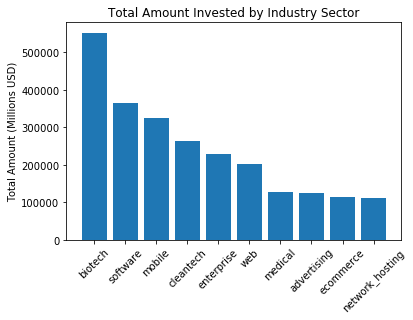

                      investor_name  total_investor
0  Kleiner Perkins Caufield & Byers         56089.1
1         New Enterprise Associates         48462.7
2                    Accel Partners         32360.6
3                     Goldman Sachs         31877.3
4                   Sequoia Capital         30197.0
5                             Intel         29846.0
6                            Google         29044.0
7                       Time Warner         28650.0
8                           Comcast         28345.0
9                 Greylock Partners         24804.9


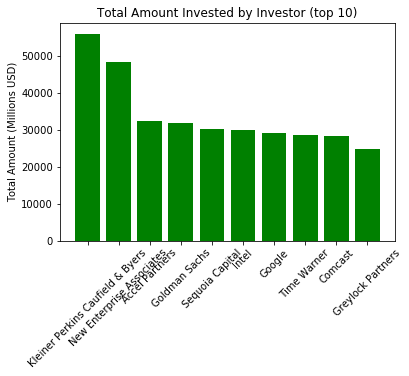

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

#2. Which category of companies attracted the most investments
query = "SELECT company_category_code, ROUND(sum(raised_amount_usd)/1000000,1) as total_category FROM investments GROUP BY company_category_code ORDER BY total_category DESC LIMIT 10;"
results = pd.read_sql(query,conn)
print(results.head(10))
y_pos = np.arange(len(results))
plt.bar(y_pos, results["total_category"])
plt.xticks(y_pos, results["company_category_code"], rotation=45)
plt.ylabel("Total Amount (Millions USD)")
plt.title("Total Amount Invested by Industry Sector")
plt.show()

#3. Which investor contributed the most money across all startups?
query = "SELECT DISTINCT investor_name, ROUND(sum(raised_amount_usd)/1000000,1) as total_investor FROM investments GROUP BY investor_name ORDER BY total_investor DESC LIMIT 10;"
results = pd.read_sql(query,conn)
print(results.head(10))
y_pos = np.arange(len(results))
plt.bar(y_pos, results["total_investor"], color="green")
plt.xticks(y_pos, results["investor_name"], rotation=45)
plt.ylabel("Total Amount (Millions USD)")
plt.title("Total Amount Invested by Investor (top 10)")
plt.show()


            investor_name  mean_investment
0  Marlin Equity Partners           2600.0
1             BrightHouse           2350.0
2             GI Partners           1050.0
3           Sprint Nextel            833.3
4    Siemens PLM Software            750.0
5                 Comcast            629.9
6    Eagle River Holdings            614.2
7             Time Warner            520.9
8   Laurel Crown Partners            450.0
9                   Intel            397.9


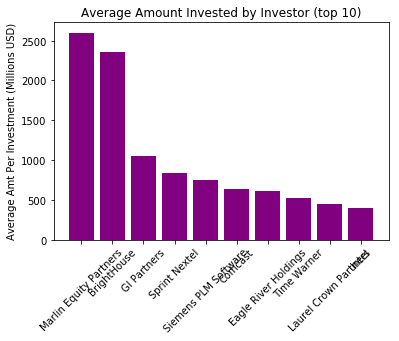

  funding_round_type  total_investment
0          series-c+         1328767.3
1            venture          652782.5
2           series-b          641633.9
3           series-a          432710.8
4           post-ipo          154588.0
5              other           92536.3
6     private-equity           80799.4
7              angel           24810.4
8       crowdfunding              32.5
9               None               NaN


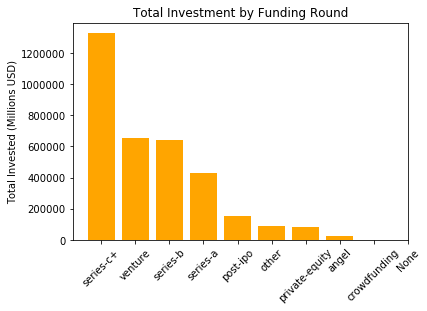

In [17]:
#4. Which investor contributed the most money per startup
query = "SELECT DISTINCT investor_name, ROUND(AVG(raised_amount_usd)/1000000,1) as mean_investment FROM investments GROUP BY investor_name ORDER BY mean_investment DESC LIMIT 10;"
results = pd.read_sql(query,conn)
print(results.head(10))

y_pos = np.arange(len(results))
plt.bar(y_pos, results["mean_investment"], color="purple")
plt.xticks(y_pos, results["investor_name"], rotation=45)
plt.ylabel("Average Amt Per Investment (Millions USD)")
plt.title("Average Amount Invested by Investor (top 10)")
plt.show()


#5. Which funding round was the most popular, which funding round the least popular
query = "SELECT funding_round_type, ROUND(SUM(raised_amount_usd)/1000000,1) as total_investment FROM investments GROUP BY funding_round_type ORDER BY total_investment DESC LIMIT 10;"
results = pd.read_sql(query,conn)
print(results.head(10))

y_pos = np.arange(len(results))
plt.bar(y_pos, results["total_investment"], color="orange")
plt.xticks(y_pos, results["funding_round_type"], rotation=45)
plt.ylabel("Total Invested (Millions USD)")
plt.title("Total Investment by Funding Round")
plt.show()

## Conclusions

The analysis shows that biotech companies have received the most startup funding over time (500 trillion) with software companies coming in second at 350 trillion.  It is also observed that there are some large players in the startup market that account for a large portion of investments.  In particular, Kleiners, Perkins and Caufield has accounted for close to 60 trillion in investments.  Nevertheless the big players appear to diversify their investments over more companies and most do not show up on the top 10 list of firms that are in the top 10 per amount invested.  The exception here is TimeWarner.  Not surprisingly most investment comes in the late stage of development (meaning series C investments) when there is greater assurance of success.

### Future work

Could try to reduce memory constraints further to 1MB by dumping out all of the unecessary variables and converting float values into float values requiring smaller storage space where possible.  The data could also be linked to the other data in the repository and a relational database designed to link the datasets together and reduce overall disk space.